In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#! cp /content/drive/MyDrive/mnist_sg/utils.py .
import utils
#! cp /content/drive/MyDrive/mnist_sg/snn_utils.py .
import snn_utils

#! cp /content/drive/MyDrive/mnist_sg/base_model.py .

import base_model

#! cp /content/drive/MyDrive/mnist_sg/lenet_decolle_model.py .

import lenet_decolle_model

In [2]:
import pickle
 
def load_object(filename):
    try:
        with open(filename, "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)
 
gen_train = load_object("gen_train.pickle")
gen_test=load_object("gen_test.pickle")

In [14]:
gen_train.pin_memory_device = 'cpu' # Does not work without this

In [15]:
import torch
import pylab as plt
device = 'cpu' #cpu/ cuda (available one)

def iter_mnist(gen_train, batchsize=100, T=1000, max_rate = 20):
    datait = iter(gen_train)
    for raw_input, raw_labels in datait:
        data, labels1h = snn_utils.image2spiketrain(raw_input, raw_labels, max_duration=T, gain=max_rate)
        data_t = torch.FloatTensor(data)
        labels_t = torch.Tensor(labels1h)
        yield data_t, labels_t

T = 300 #duration of sequence
data, target = next(iter_mnist(gen_train, T=T))
data = data.to(device)
target = target.to(device)
print(data.shape)

def decolle_loss(r, s, tgt):
    loss_tv = 0
    for i in range(len(r)):
        loss_tv += loss(r[i],tgt) 
    return loss_tv

loss = torch.nn.SmoothL1Loss()
convnet = lenet_decolle_model.LenetDECOLLE( out_channels=10,
                    Nhid=[32,64], #Number of convolution channels
                    Mhid=[128],
                    kernel_size=[7],
                    pool_size=[2,2],
                    input_shape=data.shape[2:],
                    alpha=[.95],
                    alpharp=[.65],
                    beta=[.92],
                    num_conv_layers=2,
                    num_mlp_layers=1,
                    lc_ampl=.5).to(device)



/home/user/mambaforge/envs/snn/lib/python3.10/site-packages/torch/utils/data/dataloader.py:598: UserWarning: pin memory device is set and pin_memory flag is not used then device pinned memory won't be usedplease set pin_memory to true, if you need to use the device pin memory
  warnings.warn(warn_msg)


torch.Size([300, 100, 1, 28, 28])


In [18]:
PATH = 'mnist_network_sg_conv.pth'
convnet.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

RuntimeError: Error(s) in loading state_dict for LenetDECOLLE:
	Missing key(s) in state_dict: "LIF_layers.0.base_layer.bias", "LIF_layers.1.base_layer.bias". 
	size mismatch for LIF_layers.0.base_layer.weight: copying a param with shape torch.Size([16, 1, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 1, 7, 7]).
	size mismatch for LIF_layers.1.base_layer.weight: copying a param with shape torch.Size([32, 16, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 32, 7, 7]).
	size mismatch for LIF_layers.2.base_layer.weight: copying a param with shape torch.Size([64, 1568]) from checkpoint, the shape in current model is torch.Size([128, 3136]).
	size mismatch for LIF_layers.2.base_layer.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for readout_layers.0.weight: copying a param with shape torch.Size([10, 3136]) from checkpoint, the shape in current model is torch.Size([10, 6272]).
	size mismatch for readout_layers.1.weight: copying a param with shape torch.Size([10, 1568]) from checkpoint, the shape in current model is torch.Size([10, 3136]).
	size mismatch for readout_layers.2.weight: copying a param with shape torch.Size([10, 64]) from checkpoint, the shape in current model is torch.Size([10, 128]).

In [11]:
opt = torch.optim.Adamax(convnet.get_trainable_parameters(), lr=.00001, betas=[0., .95]) # lr=0.0001/0.001 #will try changing learning rate after few epochs

for e in range(20):
    accuracy=[]
    error = []
    for data, label in iter_mnist(gen_train, T=T):
        convnet.train()
        loss_hist = 0
        data_d = data.to(device)
        label_d = label.to(device)
        convnet.init(data_d.transpose(0,1), burnin=100)
        readout = 0
        for n in range(T):
            st, rt, ut = convnet.forward(data_d[n])        
            loss_tv = decolle_loss(rt, st, label_d[n])
            loss_tv.backward()
            opt.step()
            opt.zero_grad()
            loss_hist += loss_tv
            readout += rt[-1]
        error += (readout.argmax(axis=1)!=label_d[-1].argmax(axis=1)).float()
        accuracy+=(readout.argmax(axis=1)==label_d[-1].argmax(axis=1)).float()
    print('Training Error', torch.mean(torch.Tensor(error)).data)
    print('Training accuracy', torch.mean(torch.Tensor(accuracy)).data)     
    print('Epoch', e, 'Loss', loss_hist.data)
    PATH = '/content/drive/MyDrive/mnist_sg/mnist_network_sg_conv.pth'
    torch.save(convnet.state_dict(), PATH)

Training Error tensor(0.9052)
Training accuracy tensor(0.0948)
Epoch 0 Loss tensor(51.1226, device='cuda:0')
Training Error tensor(0.9072)
Training accuracy tensor(0.0928)
Epoch 1 Loss tensor(50.6542, device='cuda:0')


KeyboardInterrupt: ignored

In [ ]:
PATH = '/content/drive/MyDrive/new_mnist_fg/mnist_network_fg.pth'
net.load_state_dict(torch.load(PATH))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
#from resources.plotcm import plot_confusion_matrix

import numpy

error = []
accuracy=[]
y_pred = []
y_true = []


for data, label in iter_mnist(gen_test, T=T):
        loss_hist = 0
        data_d = data.to(device)
        label_d = label.to(device)
        net.init(data_d.transpose(0,1), burnin=100)
        readout = 0
        with torch.no_grad():
          for n in range(T):
             st, rt, ut=net.forward(data_d[n])
             loss_tv = decolle_loss(rt, st, label_d[n])
             
             loss_hist += loss_tv
             readout += rt[-1]
          output = (readout.argmax(axis=1)).data.cpu().numpy()
          y_pred.extend(output)
          labels =(label_d[-1].argmax(axis=1)).data.cpu().numpy()
          y_true.extend(labels)
          accuracy+=(readout.argmax(axis=1)==label_d[-1].argmax(axis=1)).float()
          error += (readout.argmax(axis=1)!=label_d[-1].argmax(axis=1)).float()
print('Testing Error', torch.mean(torch.Tensor(error)).data)
print('Testing accuracy', torch.mean(torch.Tensor(accuracy)).data)
accuracy=torch.mean(torch.Tensor(accuracy)).item()
# Build confusion matrix
classes = ('O', '1', '2', '3', '4',
        '5', '6', '7', '8', '9')
cm = confusion_matrix(y_true, y_pred)



cm

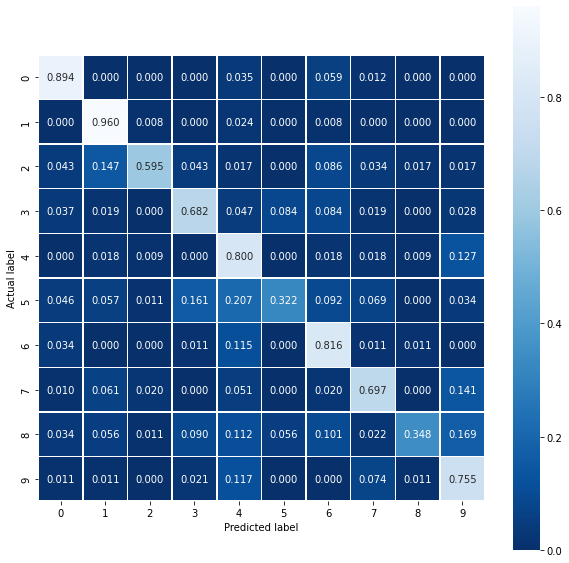

In [ ]:
# Used for Confusion Matrix
from sklearn import metrics
import seaborn as sns
import numpy as np
cm = metrics.confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



plt.figure(figsize=(10,10))
sns.heatmap(cm_normalized, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
#all_sample_title = 'Accuracy = {} %'.format(np.accuracy)*100 
#plt.title(all_sample_title, size = 5);
#plt.savefig('/content/drive/MyDrive/coding_mnist_sg/new_mnist_fg/confusion_matrix_10epoch_10.svg')